Детектор аномалии на принципе многократной прогонки реконструкции входного образца до сходимости латентного вектора.
Критерий аномальности - расстояние от первоначального латентного вектора до сошедшего.

In [37]:
from dataclasses import dataclass
from datetime import datetime

import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np 
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from tqdm.auto import tqdm
from torchfuzzy import FuzzyLayer, DefuzzyLinearLayer, FuzzyBellLayer, DefuzzyMaxLayer
import piqa
import sklearn.metrics as metrics
from sklearn.manifold import TSNE
from torchvision.transforms import v2
from torchinfo import summary
from matplotlib.colors import ListedColormap


In [38]:
batch_size = 256
learning_rate_ae = 1e-3
#learning_rate_ad = 1e-4
num_epochs_ae = 25
#num_epochs_ad = 100
latent_dim = 3
mnist_class_anomaly = 4
kernels = 8
fuzzy_rules_count = 32

prefix = f"fuzzy_ad"
writer = SummaryWriter(f'runs/mnist/{prefix}_{datetime.now().strftime("%Y%m%d-%H%M%S")}')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

binary_cmap = ListedColormap(['yellow', 'red'], N=2)
ssim = piqa.SSIM(window_size = 11, n_channels=1, reduction='none').to(device)
device

device(type='cuda')

## Датасет

1. Исключаем класс аномалии `mnist_class_anomaly` из общей выборк
2. Убираем метки с остальных классов
   

In [39]:
def norm_and_transform(x):
    nimg = x.view(-1, 28, 28)
    nimg = torch.clamp(nimg, 0, 1)
    return nimg

def clamp(x):
    #nimg = 2.0*(x.view(-1, 28, 28) - 0.5)
    nimg = torch.clamp(x, 0, 1)
    return nimg

transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Lambda(norm_and_transform)
])

augmentation = transforms.Compose([
    transforms.RandomRotation(15, fill=0), 
    transforms.RandomAffine(degrees=5, translate=(0.1, 0.1), fill=0), 
    #transforms.RandomCrop(size=26),
    #transforms.Resize(size=(28, 28)),
    transforms.Lambda(clamp)
])

In [40]:
def get_target_and_mask(target_label):
    t = target_label
    return t 

train_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=True, 
    transform = transform,
    target_transform = transforms.Lambda(lambda x: get_target_and_mask(x))
)

idx = (train_data.targets != mnist_class_anomaly)
train_data.targets = train_data.targets[idx]
train_data.data = train_data.data[idx]
len(train_data)

54158

загружаем тестовую выборку

In [41]:
test_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=False, 
    transform=transform, 
    target_transform = transforms.Lambda(lambda x: get_target_and_mask(x))
)
len(test_data)

10000

Создаем итераторы датасетов

In [42]:

train_loader = torch.utils.data.DataLoader(
    train_data, 
    batch_size=batch_size, 
    shuffle=True,
    
)
test_loader = torch.utils.data.DataLoader(
    test_data, 
    batch_size=batch_size, 
    shuffle=False,
)

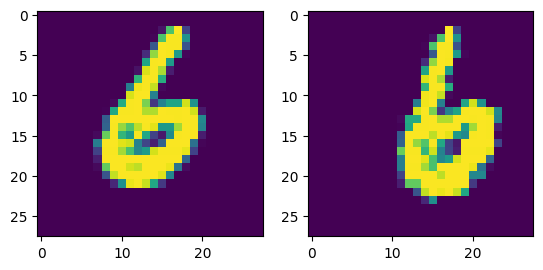

In [43]:
for data,_ in iter(train_loader):
    R, C = 1, 2
    plt.subplot(R, C, 1)
    plt.imshow(data[0].squeeze())
    plt.subplot(R, C, 2)
    plt.imshow(augmentation(data)[0].squeeze())
    
    
    break

## Модель

In [44]:
class FAD(nn.Module):
    def __init__(self, fuzzy_rules_count, latent_dim, kernels):
        super(FAD, self).__init__()
                
        self.encoder = nn.Sequential(
            nn.Conv2d(1, kernels, kernel_size = 5), 
            nn.Conv2d(kernels, kernels, kernel_size = 5), 
            nn.BatchNorm2d(kernels), 
            nn.SiLU(),

            nn.Conv2d(kernels, 2*kernels, kernel_size = 5), 
            nn.Conv2d(2*kernels, 2*kernels, kernel_size = 5), 
            nn.BatchNorm2d(2*kernels), 
            nn.SiLU(),

            nn.Conv2d(2*kernels, 4*kernels, kernel_size = 5), 
            nn.Conv2d(4*kernels, 4*kernels, kernel_size = 5), 
            nn.BatchNorm2d(4*kernels), 
            nn.SiLU(),

            nn.Conv2d(4*kernels, 8*kernels, kernel_size = 4), 
            nn.BatchNorm2d(8*kernels), 
            nn.SiLU(),            
        )

        self.latent = nn.Sequential(
            nn.Flatten(),
            nn.Linear(8*kernels, latent_dim)
        )
        self.fuzzy_rules_count = fuzzy_rules_count
        initial_centroids = (0.5-np.random.rand(fuzzy_rules_count, latent_dim))
        initial_scales = np.ones((fuzzy_rules_count, latent_dim))

        self.fuzzy_core = nn.Sequential(
            FuzzyLayer.from_centers_and_scales(initial_centroids, initial_scales)
        )

        self.defuzzy = nn.Parameter(torch.rand(fuzzy_rules_count, 28 * 28))


    def forward(self, x):
        """
        Выход энкодера для чистого VAE.
        
        Args:
            x (torch.Tensor): Входной вектор.
            eps (float): Небольшая поправка к скейлу для лучшей сходимости и устойчивости.
        
        Returns:
            mu, logvar, z, dist
        """
        enc = self.encoder(x)
        latent = self.latent(enc)
        fz = self.fuzzy_core(latent)
        
        return fz, latent
    
    def inference(self, fz):
        #wfz = (F.one_hot(fz.max(-1).indices, self.fuzzy_rules_count)).float()
        mul = fz.reshape(-1, self.fuzzy_rules_count, 1).repeat(1, 1, 28 * 28) * self.defuzzy
        out = mul.sum(1).reshape(-1, 1, 28, 28)
        return out
        
#inp = torch.rand(10, 1, 28, 28)
m = FAD(fuzzy_rules_count, latent_dim, 16)
#fz, mu = m.forward(inp)
#m.inference(fz).shape
#summary(m, input_size=(batch_size, 1, 28, 28))


In [45]:
model = FAD(latent_dim=latent_dim, fuzzy_rules_count=fuzzy_rules_count, kernels=kernels).to(device)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of parameters: {num_params:,}')

summary(model, input_size=(batch_size, 1, 28, 28))

Number of parameters: 108,555


Layer (type:depth-idx)                   Output Shape              Param #
FAD                                      [256, 32]                 25,088
├─Sequential: 1-1                        [256, 64, 1, 1]           --
│    └─Conv2d: 2-1                       [256, 8, 24, 24]          208
│    └─Conv2d: 2-2                       [256, 8, 20, 20]          1,608
│    └─BatchNorm2d: 2-3                  [256, 8, 20, 20]          16
│    └─SiLU: 2-4                         [256, 8, 20, 20]          --
│    └─Conv2d: 2-5                       [256, 16, 16, 16]         3,216
│    └─Conv2d: 2-6                       [256, 16, 12, 12]         6,416
│    └─BatchNorm2d: 2-7                  [256, 16, 12, 12]         32
│    └─SiLU: 2-8                         [256, 16, 12, 12]         --
│    └─Conv2d: 2-9                       [256, 32, 8, 8]           12,832
│    └─Conv2d: 2-10                      [256, 32, 4, 4]           25,632
│    └─BatchNorm2d: 2-11                 [256, 32, 4, 4]       

## Losses

In [46]:
def compute_loss(imgs, raw_inferences, fz):
    inp_batch_size = imgs.shape[0]

    rimgs = imgs.repeat_interleave(fuzzy_rules_count,dim=0)
    rdfz = raw_inferences.repeat(inp_batch_size, 1).reshape(-1, 1, 28, 28).clamp(0, 1)

    matches = 1 - ssim(rdfz, rimgs).reshape(-1, fuzzy_rules_count)

    best_matches = matches.min(-1)
    matches_mask = (F.one_hot(best_matches.indices, fuzzy_rules_count)).float()
    
    #loss_recon = 1 - ssim(x, recon_x.clamp(0, 1))
    #loss_recon = (x-recon_x).square().sum(-1).sum(-1)#(1 - ssim(recon_x, x))#
    loss_recon = best_matches.values.mean() + (fz - matches_mask).square().sum(-1).mean()
    return loss_recon
    

In [47]:
def compute_fuzzy_loss(fz):
    winner_mask = (F.one_hot(fz.max(-1).indices, fuzzy_rules_count)).detach().float().to(device)
    return (winner_mask - fz).abs().sum(-1).mean() # +  (1 - fz.qu.max(-1)).mean() #(0.999 - (tops[:,0]+tops[:,1]).clamp(max=0.999)).mean() + tops[:, 2].clamp(min=0.001).mean()

In [48]:
def keep_eigenvals_positive_loss(layer, eps = 1e-15):
    ev = layer.get_transformation_matrix_eigenvals().real.min()
    ev = torch.clamp(ev, max=eps)
    return -ev

In [49]:
def fuzzy_term_volume_loss(layer):
    #dfz = fz.detach().mean(0)
    
    ev = layer.get_transformation_matrix_eigenvals().real.mean(-1)
    ev = 1/ev.mean()
    
    return ev#(1 - fz.max(-1).values).abs().mean()#

In [50]:
def get_arate(inp):
    fz_c, mu = model.forward(inp)
    
    return fz_c.sum(-1).cpu().numpy() #(1 - ssim(x_recon.clamp(0, 1), inp)).cpu().numpy()#xent_continuous_ber((x_recon + 1)/2, (inp + 1)/2).cpu().numpy()# #ssim((inp + 1)/2, (recon_x+1)/2).cpu().numpy() #fz.sum(-1).cpu().numpy()#

## Train AE

In [51]:
optimizer_ae = torch.optim.Adam(model.parameters(), lr=learning_rate_ae)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer_ae, learning_rate_ae, epochs=num_epochs_ae, steps_per_epoch=len(train_loader))
#sched = torch.optim.lr_scheduler.ConstantLR(optimizer_ae, learning_rate)

In [52]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    
def train(model, dataloader, optimizer, sched, prev_updates, epoch, writer=None):
    model.train()  
    
    for batch_idx, (data, _) in enumerate(tqdm(dataloader, disable=True)):
        data = data.to(device)
        adata = augmentation(data)
        
        optimizer.zero_grad()  
        
        fz, mu = model.forward(adata)  
        #x_reconstruct = model.inference(fz)
        
        loss_reconstruct = compute_loss(data, model.defuzzy, fz)
        
        ev_loss = keep_eigenvals_positive_loss(model.fuzzy_core[0])
        if ev_loss.item() > 0:
            ev_loss.backward(retain_graph=True)

        
        loss_reconstruct.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1e-2)
        optimizer.step()  

        if sched is not None:
            sched.step()
        
    if writer is not None:
        writer.add_scalar('FAD/LR', get_lr(optimizer), global_step=epoch)
        
    return prev_updates + len(dataloader)

In [53]:
#fixed_random_z = torch.randn(16, fuzzy_rules_count).to(device)

def test(model, dataloader, cur_step, epoch, writer=None):
    model.eval() 

    test_recon_loss = 0
    test_fz_loss = 0
    test_fz_sum_loss = 0
    
    lab_true = []
    lab_pred = []

    with torch.no_grad():
        for data, lab in tqdm(test_loader, desc='Test MNIST', disable=True):
            data = data.view((-1,1,28,28)).to(device)
            rates = get_arate(data)
            
            for f, l in  zip(rates, lab):
                lab_pred.append(f)        
                if l == mnist_class_anomaly:
                    lab_true.append(1)
                else:
                    lab_true.append(0)
                        
    fpr, tpr, _ = metrics.roc_curve(lab_true, lab_pred)
    roc_auc = metrics.auc(fpr, tpr)
    
    embedings = []
    labels_expected = []
    
    
    with torch.no_grad():
        for data, target in tqdm(dataloader, desc='Testing', disable=True):
            data = data.to(device)

            fz, mu = model.forward(data)  
            dfz = model.inference(fz)
            embedings.append(mu.cpu().numpy())
            labels_expected.append((target == mnist_class_anomaly).cpu().numpy())

            loss_recon = compute_loss(data, model.defuzzy, fz)
            fz_loss = fuzzy_term_volume_loss(model.fuzzy_core[0])
            fz_sum = compute_fuzzy_loss(fz)
            
            test_recon_loss += loss_recon.item()
            test_fz_loss += fz_loss.item()
            test_fz_sum_loss += fz_sum.item()
            

    embedings = np.concatenate(embedings, axis=0)
    labels_expected = np.concatenate(labels_expected, axis=0)
   
    test_recon_loss /= len(dataloader)
    test_fz_loss /= len(dataloader)
    test_fz_sum_loss /= len(dataloader)
    
    print(f'[{cur_step}] Reconstruction loss: {test_recon_loss:.4f}, VOL: {test_fz_loss:.4f} SUM: {test_fz_sum_loss:.2f} AUC: {roc_auc:.4f}')
    #print(f'Average activation stats: {model.decoder.fuzzy[2].get_norm_stats()}')
    #print(f'Average centroid stats: {model.decoder.fuzzy[0].get_average_centroid()}')
    if writer is not None:
        writer.add_scalar('FAD/AUC', roc_auc, global_step=cur_step)
        writer.add_scalar('FAD/Reconstruction', test_recon_loss, global_step=cur_step)
        writer.add_scalar('FAD/Volume', test_fz_loss, global_step=cur_step)
        writer.add_scalar('FAD/Sum', test_fz_sum_loss, global_step=cur_step)
        
        fig, ax = plt.subplots(1, 2, figsize=(9, 4))
        centroids_c = model.fuzzy_core[0].get_centroids().detach().cpu().numpy()
        
        ax[0].scatter(embedings[:, 0],      embedings[:,  1], c=labels_expected, cmap=binary_cmap, s=2)
        ax[0].scatter(centroids_c[:, 0],      centroids_c[:, 1], marker='1', c='green', s= 50)
        
        #ax[0].set_xlim(-1, 1)
        #ax[0].set_ylim(-1, 1)
        
        ax[1].scatter(embedings[:, 0],      embedings[:,  2], c=labels_expected, cmap=binary_cmap, s=2)
        ax[1].scatter(centroids_c[:, 0],      centroids_c[:, 2], marker='1', c='green', s= 50)
        
        #ax[1].set_xlim(-1, 1)
        #ax[1].set_ylim(-1, 1)
        
        act_fz = torch.diag(torch.ones(fuzzy_rules_count)).to(device)
        samples = model.inference(act_fz)
        img_idx = 0
        fign, axn = plt.subplots(8, 1 + fuzzy_rules_count//8, figsize=(1 + fuzzy_rules_count//8, 8), squeeze=False)
        for i in range(8):
            if img_idx >= fuzzy_rules_count:
                continue
            for j in range(fuzzy_rules_count//8):
                axn[i, j].imshow(samples[img_idx].view(28, 28).cpu().detach().numpy(), cmap='gray')
                axn[i, j].axis('off')
                img_idx += 1

        writer.add_figure('FAD/Emedding', fig, global_step=cur_step)
        writer.add_figure('FAD/Samples', fign, global_step=cur_step)

In [54]:
prev_updates = 0

In [55]:
for epoch in range(num_epochs_ae):
    prev_updates = train(model, train_loader, optimizer_ae, sched, prev_updates, epoch, writer=writer)
    test(model, test_loader, prev_updates, epoch, writer=writer)
    #scheduler.step()

[212] Reconstruction loss: 2.0284, VOL: 0.9871 SUM: 3.33 AUC: 0.5429
[424] Reconstruction loss: 1.8760, VOL: 0.9686 SUM: 2.12 AUC: 0.7092
[636] Reconstruction loss: 1.8017, VOL: 0.9585 SUM: 1.86 AUC: 0.4308
[848] Reconstruction loss: 1.7117, VOL: 0.9425 SUM: 2.08 AUC: 0.5185
[1060] Reconstruction loss: 1.5858, VOL: 0.9306 SUM: 1.99 AUC: 0.4996
[1272] Reconstruction loss: 1.4206, VOL: 0.9235 SUM: 1.36 AUC: 0.4696
[1484] Reconstruction loss: 1.3405, VOL: 0.9182 SUM: 1.37 AUC: 0.5784
[1696] Reconstruction loss: 1.2443, VOL: 0.9114 SUM: 1.16 AUC: 0.2710
[1908] Reconstruction loss: 1.2291, VOL: 0.9090 SUM: 1.07 AUC: 0.4522
[2120] Reconstruction loss: 1.2319, VOL: 0.9109 SUM: 1.10 AUC: 0.2983
[2332] Reconstruction loss: 1.2313, VOL: 0.9123 SUM: 1.02 AUC: 0.3998
[2544] Reconstruction loss: 1.1921, VOL: 0.9143 SUM: 1.03 AUC: 0.2713
[2756] Reconstruction loss: 1.1643, VOL: 0.9127 SUM: 1.04 AUC: 0.3855
[2968] Reconstruction loss: 1.1688, VOL: 0.9122 SUM: 1.02 AUC: 0.4276
[3180] Reconstruction lo

## Train AD

In [56]:
# params = list(model.fuzzy_core.parameters()) + list(model.defuzzy.parameters()) + list(model.latent.parameters())
# optimizer_ad = torch.optim.Adam(params, lr = learning_rate_ad)
# sched_ad = torch.optim.lr_scheduler.ConstantLR(optimizer_ad, learning_rate_ad)
# #sched_ad = torch.optim.lr_scheduler.OneCycleLR(optimizer_ad, learning_rate_ad, epochs=num_epochs_ad, steps_per_epoch=len(train_loader))

In [57]:
# def train_ad(model, dataloader, optimizer, sched, prev_updates, epoch, writer=None):
#     model.train()  
    
#     for batch_idx, (data, _) in enumerate(tqdm(dataloader, disable=True)):
#         n_upd = prev_updates + batch_idx
        
#         data = data.to(device)
#         adata = augmentation(data)
        
#         optimizer.zero_grad()  
        
#         fz_c, dfz, mu = model.half_pass(adata)  
#         #x_reconstruct = model.decoder_pass(mu)
        
#         loss_reconstruct = compute_ae_loss(data, dfz)        
        
#         ev_loss = keep_eigenvals_positive_loss(model.fuzzy_core[0])
#         if ev_loss.item() > 0:
#             ev_loss.backward(retain_graph=True)

#         loss_reconstruct.backward()
        
#         torch.nn.utils.clip_grad_norm_(model.parameters(), 1e-2)
#         optimizer.step()  

#         if sched is not None:
#             sched.step()
        
#     if writer is not None:
#         writer.add_scalar('FAD/LR', get_lr(optimizer), global_step=epoch)
        
#     return prev_updates + len(dataloader)

In [58]:
# for epoch in range(num_epochs_ad):
#     prev_updates = train_ad(model, train_loader, optimizer_ad, sched_ad, prev_updates, epoch, writer=writer)
#     test(model, test_loader, prev_updates, epoch, writer=writer)
#     #scheduler.step()

In [59]:
keep_eigenvals_positive_loss(model.fuzzy_core[0])

tensor(-1.0000e-15, device='cuda:0', grad_fn=<NegBackward0>)

## Визуализируем результаты

In [60]:
model.eval()

FAD(
  (encoder): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
    (1): Conv2d(8, 8, kernel_size=(5, 5), stride=(1, 1))
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): SiLU()
    (4): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
    (5): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1))
    (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): SiLU()
    (8): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (9): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): SiLU()
    (12): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1))
    (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): SiLU()
  )
  (latent): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=64, out_features=3, bias=True)
  )
  (fu

In [61]:

# def get_activation_stats(model, dataloader):
#     rulestat = {}
#     with torch.no_grad():
#         for _, (data, _) in enumerate(tqdm(dataloader)):
#             data = data.to(device)
#             fz_с,fz_s, mu, rec_x = model.forward(data)
#             act_fz = fz.max(-1).indices.cpu().numpy()
#             for ind in act_fz:
#                 rulestat[ind] = rulestat.get(ind, 0) + 1
#     return rulestat

# train_stat = get_activation_stats(model, train_loader)
# test_stat = get_activation_stats(model, test_loader)

# plt.bar(list(train_stat.keys()), train_stat.values(), 0.5, color='g')
# plt.bar(list(test_stat.keys()), test_stat.values(), 0.5, color='r')

In [62]:

# def get_activation_stats_by_digit(digit, model, dataloader):
#     rulestat = {}
#     with torch.no_grad():
#         for _, (data, target) in enumerate(tqdm(dataloader)):
        
#             data = data.to(device)
#             fz, mu, rec_x, dfz = model.forward(data)
#             act_fz = fz.max(-1).indices.cpu().numpy()
#             for ind, trg in zip(act_fz, target):
#                 if trg == digit:
#                     rulestat[ind] = rulestat.get(ind, 0) + 1
#     return rulestat


# test_stat_by_digit = get_activation_stats_by_digit(8, model, test_loader)

# plt.bar(list(test_stat_by_digit.keys()), test_stat_by_digit.values(), 0.5, color='r')
# plt.xlim((-1, fuzzy_rules_count + 1))

In [63]:
# test_stat_by_digit

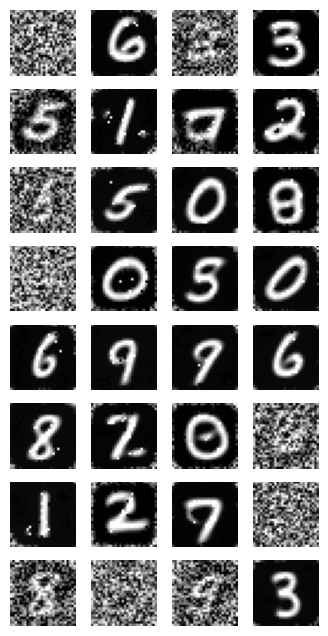

In [64]:
with torch.no_grad():
    act_fz = torch.diag(torch.ones(fuzzy_rules_count)).to(device)
    samples = model.inference(act_fz)
    img_idx = 0
    fig, ax = plt.subplots(8, fuzzy_rules_count//8, figsize=(fuzzy_rules_count//8, 8))
    for i in range(8):
        for j in range(fuzzy_rules_count//8):
            ax[i, j].imshow(samples[img_idx].view(28, 28).cpu().detach().numpy(), cmap='gray')
            ax[i, j].axis('off')
            img_idx += 1

In [65]:
# with torch.no_grad():
#     z = torch.randn(64, fuzzy_rules_count).to(device)
#     samples = model.decoder_pass(z)

#     # Plot the generated images
#     fig, ax = plt.subplots(8, 8, figsize=(8, 8))
#     for i in range(8):
#         for j in range(8):
#             ax[i, j].imshow(samples[i*8+j].view(28, 28).cpu().detach().numpy(), cmap='gray')
#             ax[i, j].axis('off')


In [66]:
def get_arate(inp):
    fz, mu = model.forward(inp)
    x_recon = model.inference(fz)
    return (1 - ssim(x_recon.clamp(0, 1), inp)).cpu().numpy()#fz.sum(-1).cpu().numpy() #xent_continuous_ber((x_recon + 1)/2, (inp + 1)/2).cpu().numpy()# #ssim((inp + 1)/2, (recon_x+1)/2).cpu().numpy() #fz.sum(-1).cpu().numpy()#(inp - x_recon).abs().sum(-1).sum(-1).mean(-1).cpu().numpy()#

MNIST HIST:   0%|          | 0/40 [00:00<?, ?it/s]

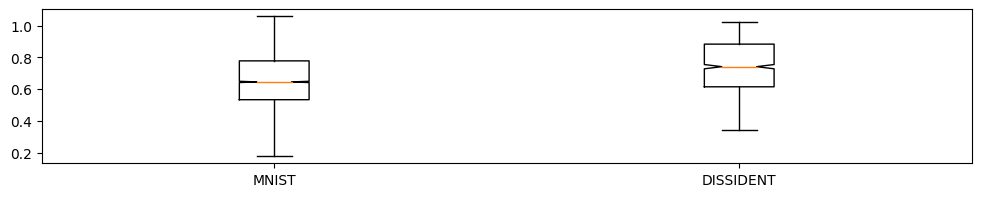

In [67]:
firings_mnist = {}
firings_mnist['MNIST'] = []
firings_mnist['DISSIDENT'] = []

with torch.no_grad():
    for data, target in tqdm(test_loader, desc='MNIST HIST'):
        data = data.view((-1,1,28,28)).to(device)
        rates = get_arate(data)
        for f, l in  zip(rates, target):
            if l != mnist_class_anomaly:
                firings_mnist['MNIST'].append(f)
            else:
                firings_mnist['DISSIDENT'].append(f)
        

labels, data = firings_mnist.keys(), firings_mnist.values()

fig = plt.figure(figsize =(12, 2))
plt.boxplot(data, notch=True, showfliers=False)
plt.xticks(range(1, len(labels) + 1), labels)
plt.show()

writer.add_figure('Anomaly Detection', fig)

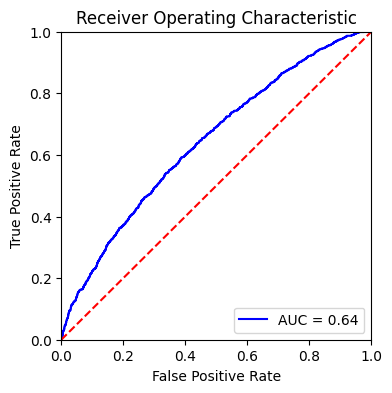

In [68]:
with torch.no_grad():
    firing_levels = []
    lab_true = []
    lab_pred = []

    for data, lab in tqdm(test_loader, desc='Test MNIST', disable=True):
        data = data.view((-1,1,28,28)).to(device)
        rates = get_arate(data)
        
        for f, l in  zip(rates, lab):
            firing_levels.append(f)
            lab_pred.append(f)        
            if l == mnist_class_anomaly:
                lab_true.append(1)
            else:
                lab_true.append(0)
                    
    fpr, tpr, threshold = metrics.roc_curve(lab_true, lab_pred)
    roc_auc = metrics.auc(fpr, tpr)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = threshold[optimal_idx]
    fig = plt.figure(figsize =(4, 4))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    writer.add_figure('ROC', fig)

Encoding:   0%|          | 0/40 [00:00<?, ?it/s]

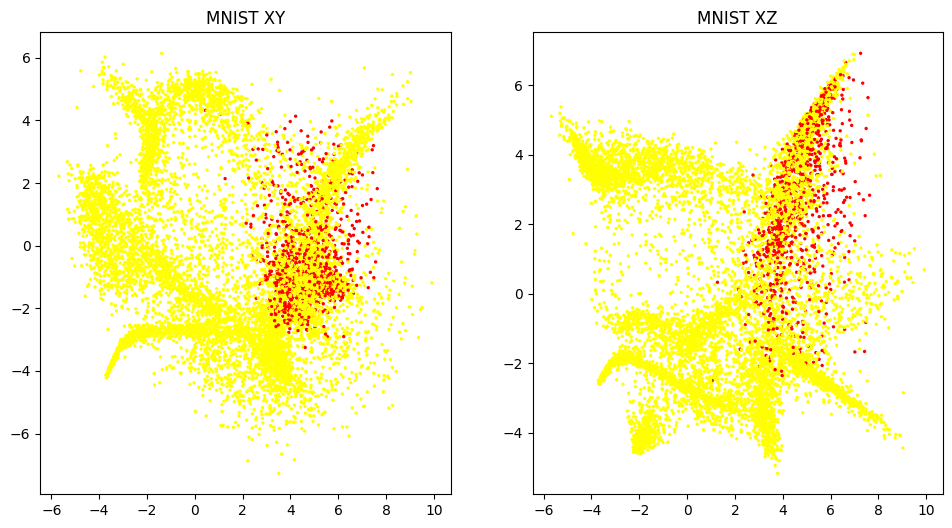

In [69]:


def show_plot():
    #centroids = model.fuzzy[0].get_centroids().detach().cpu().numpy()
    embedings = []
    labels_expected = []
    with torch.no_grad():
        for data, target in tqdm(test_loader, desc='Encoding'):
            data = data.view((-1,1,28,28)).to(device)
            fz_с, mu = model.forward(data)
            embedings.append(mu.cpu().numpy())
            labels_expected.append((target == mnist_class_anomaly).cpu().numpy())
    embedings = np.concatenate(embedings, axis=0)
    labels_expected = np.concatenate(labels_expected, axis=0)

    plt.figure(figsize=(18, 6))

    R, C = 1, 3

    plt.subplot(R, C, 1)
    plt.title("MNIST XY")
    
    plt.scatter(embedings[:, 0],      embedings[:,  1], c=labels_expected, cmap=binary_cmap, s=2)
    #plt.scatter(centroids[:, 0],      centroids[:, 1], marker='1', c='black', s= 50)

    plt.subplot(R, C, 2)
    plt.title("MNIST XZ")
    plt.scatter(embedings[:, 0],      embedings[:,  2], c=labels_expected, cmap=binary_cmap, s=2)
    #plt.scatter(centroids[:, 0],      centroids[:, 2], marker='1', c='black', s= 50)

    
show_plot()

In [70]:
def show_item_reconstructio(ind):
    for data, trg in iter(test_loader):
        data = data.to(device)
        fz, mu = model.forward(data)
        rec_x = model.inference(fz)
        plt.figure(figsize=(24, 6))

        R, C = 1, 6

        plt.subplot(R, C, 1)
        plt.imshow(data[ind].cpu().squeeze())
        plt.subplot(R, C, 2)
        plt.imshow(rec_x[ind].detach().cpu().squeeze())
        
        plt.subplot(R, C, 3)
        plt.imshow((rec_x[ind] - data[ind]).abs().detach().cpu().squeeze())
        break

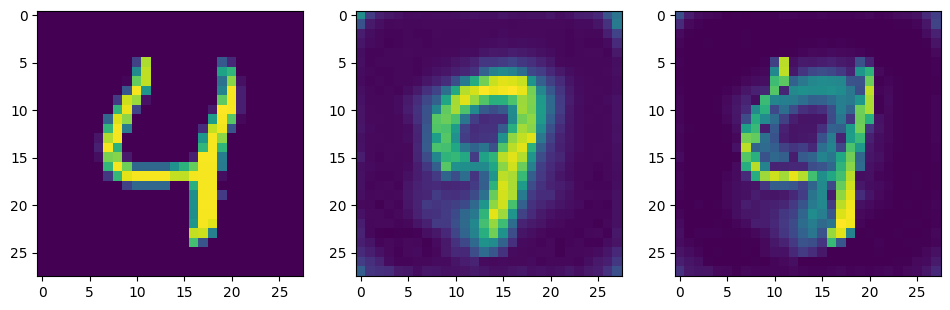

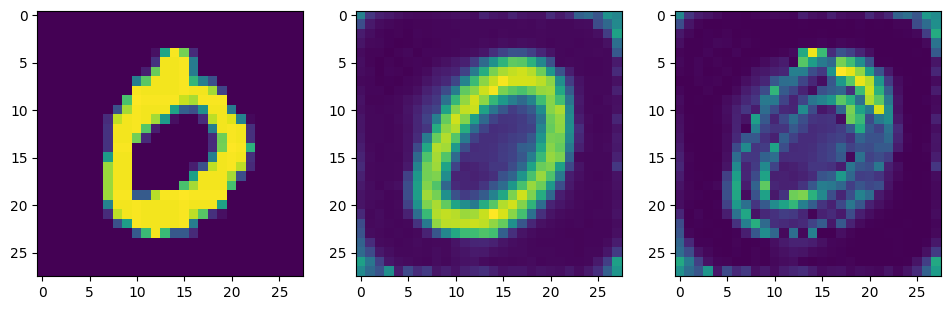

In [71]:
show_item_reconstructio(4)
show_item_reconstructio(3)

EMNIST VIS:   0%|          | 0/40 [00:00<?, ?it/s]

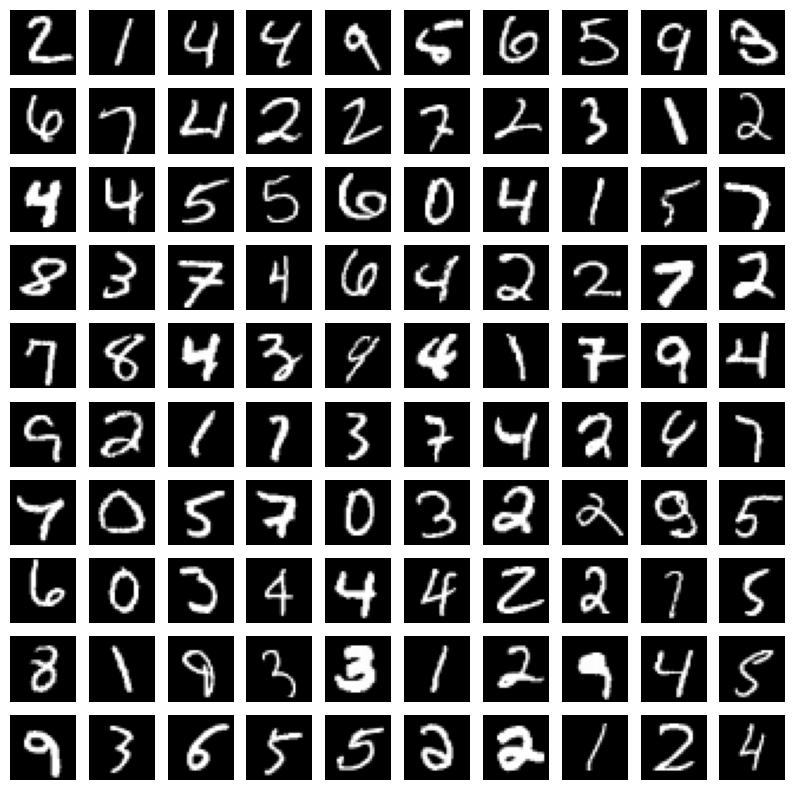

In [72]:
threshold = optimal_threshold
n = 0
fig, ax = plt.subplots(10, 10, figsize=(10, 10))
with torch.no_grad():
    for data, labels in tqdm(test_loader, desc='EMNIST VIS'):
        if n >= 100:
            break
        data = data.view((-1, 1, 28, 28)).to(device) 
        
        arate = get_arate(data)
        
        for i in range(data.shape[0]):
            if(arate[i] > threshold):
                img = data[i]
                ax[int(n / 10), int(n % 10)].imshow(img.view(28, 28).cpu().detach().numpy(), cmap='gray')
                ax[int(n / 10), int(n % 10)].axis('off')
                n = n + 1
                    
                if n >= 100:
                    break